In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_columns', None)

In [21]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path='results_3_triggers'):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_top_candidate', 
                   'trigger_asr', 'loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')

plot_df = df.merge(metadata, how='left', on='model_name')

prediction_df = plot_df[plot_df['trigger_asr']>.9]
prediction_df = prediction_df[prediction_df['loss']<.3]
plot_df_temp = prediction_df.groupby(['model_name']).agg({'loss':'min'})
prediction_df = plot_df_temp.merge(prediction_df, on=['model_name', 'loss'], how='left')
prediction_df


,model_name,loss,source_class,target_class,decoded_top_candidate,trigger_asr,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding,embedding_level,embedding_flavor_level,embedding_flavor,source_dataset,source_dataset_level,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
0,id-00000003,0.172718,7,5,light visiting,1.000000,True,1299514748,1,WarmupWithLinear,1,0,NerLinear,1,0.00005,1,16,0.01,5,0.2,BERT,0,0,bert-base-uncased,conll2003,2,0,0.1,0,one2one,1,9,{'0': 'MISC' '1': 'PER' '2': 'ORG' '3': 'LOC'},LOC,ORG,0,0.2,0,True,1,word1,0.001804,0.179923,0.086704,0.09321965336539506,10,2673.339651,118.103538,99.731186,92.332345,93.793863,90.87082787100312,93.415313,93.11320505817532,100.0,100.0,0.984414,0.923847,0.938793,0.931260,MISC,0.894253,0.861573,0.894253,0.877609,PER,0.967540,0.979815,0.967540,0.973639,ORG,0.912694,0.897233,0.912694,0.904897,LOC,0.959484,0.927596,0.959484,0.943271,None,None,None,None,None,None,None,None,None,None,0.9870466321243523,0.9377880184331797,0.9476135040745053,0.9426751592356688,MISC,0.8214285714285714,0.7840909090909091,0.8214285714285714,0.8023255813953489,PER,0.9707112970711297,0.9666666666666667,0.9707112970711297,0.9686847599164927,ORG,0.957089552238806,0.95,0.957089552238806,0.9535315985130112,LOC,No

In [22]:
asr_threshold = .9

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_filtered = df_original_merged[df_original_merged['trigger_asr']>asr_threshold]

remaining_model_names = df_filtered['model_name'].unique()
all_model_names = df_original_merged['model_name'].unique()
missing_model_names = [i for i in all_model_names if i not in remaining_model_names]
df_missing_model_names = df_original_merged[df_original_merged['model_name'].isin(missing_model_names)]
df_missing_model_names_max_asr = df_missing_model_names.groupby('model_name').agg({'trigger_asr':'max'})
df_missing_model_names = df_missing_model_names_max_asr.merge(df_missing_model_names, on='model_name', how='left')

df_filtered = pd.concat([df_filtered, df_missing_model_names])

min_loss_df = df_filtered.groupby('model_name', as_index=False).agg({'loss':'min'})

def get_entry_with_min_loss(x):
    model_name = x['model_name']
    loss = x['loss']
    asr = x['trigger_asr']
    min_loss = min_loss_df[min_loss_df['model_name'] == model_name]['loss']
    x['mask'] = ((loss==min_loss).item()) & (asr>asr_threshold)
    return x

df_filtered = df_filtered.apply(get_entry_with_min_loss, axis=1)
# df_original_merged['mask']
df_filtered = df_filtered[df_filtered['mask']]
df_filtered

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding,embedding_level,embedding_flavor_level,embedding_flavor,source_dataset,source_dataset_level,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged,trigger_asr_x,trigger_asr_y,mask
91,7,8,averaged £,0.914286,1.818062,id-00000173,False,2093536743,1,WarmupWithLinear,0,0,NerLinear,1,0.00005,0,8,0.01,5,0.2,BERT,0,0,bert-base-uncased,ontonotes-5.0,1,0,0.1,None,None,0,13,{'0': 'GPE' '1': 'PERSON' '2': 'DATE' '3': 'MO...,None,None,None,None,None,None,None,None,0.016502,0.061240,0.061240,None,10,17436.762862,441.553612,97.366844,94.734132,94.734132,None,91.216187,None,100.0,None,0.985197,0.918431,0.916675,0.917552,GPE,0.924793,0.945154,0.924793,0.934863,PERSON,0.948184,0.959745,0.948184,0.953929,DATE,0.883366,0.850308,0.883366,0.866522,MONEY,0.882306,0.880221,0.882306,0.881262,NORP,0.9117379435850773,0.9290681502086231,0.9117379435850773,0.9203214695752009,PERCENT,0.9147121535181236,0.9147121535181236,0.9147121535181236,0.9147121535181236,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.866522,

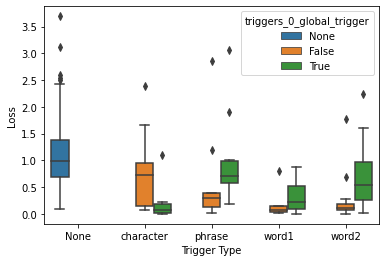

In [23]:
df_filtered = df_filtered.sort_values('triggers_0_trigger_executor_name')
sns.boxplot(data=df_filtered, x='triggers_0_trigger_executor_name', y='loss', hue='triggers_0_global_trigger')
# sns.stripplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', hue='triggers_0_global_trigger')
plt.xlabel('Trigger Type')
plt.ylabel('Loss')
plt.savefig('boxplot_two_trigger_asr>90pct_min_loss.jpg', dpi=2000)

In [24]:
df_filtered.groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

,model_name
triggers_0_trigger_executor_name,
None,69
character,23
phrase,19
word1,21
word2,23


In [25]:
df_original_merged.groupby('model_name', as_index=False).min().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

,model_name
triggers_0_trigger_executor_name,
None,95
character,24
phrase,24
word1,23
word2,24


<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='trigger_asr'>

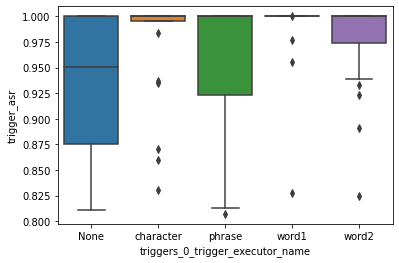

In [98]:
sns.boxplot(data=df_original_merged, x='triggers_0_trigger_executor_name', y='trigger_asr')

<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

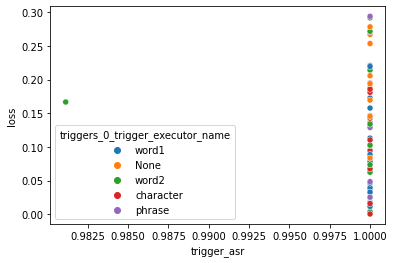

In [28]:
sns.scatterplot(data=prediction_df, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='loss'>

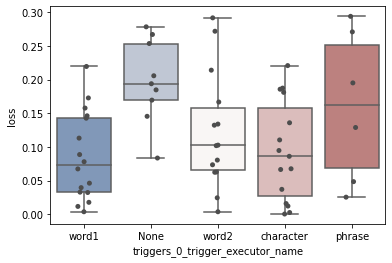

In [51]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [ ]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='poisoned', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='poisoned', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [38]:
lst=['poisoned', 'triggers_0_trigger_executor_name', 'model_name']
kept_df = prediction_df[list(df.columns)+lst]
kept_df = prediction_df.dropna()
kept_df.groupby(['poisoned', 'embedding_flavor']).agg({'model_name':'count'})

model_name
poisoned embedding_flavor                     
False    bert-base-uncased                   2
         distilbert-base-cased               6
         google/mobilebert-uncased           1
True     bert-base-uncased                  16
         distilbert-base-cased              11
         google/mobilebert-uncased          12
         roberta-base                       12

In [39]:
kept_df.groupby(['poisoned', 'source_dataset']).agg({'model_name':'count'})

model_name
poisoned source_dataset            
False    bbn-pcet                 6
         ontonotes-5.0            3
True     bbn-pcet                16
         conll2003               17
         ontonotes-5.0           18

In [48]:
metadata.triggers_0_trigger_executor_name

0        None
1        None
2        None
3       word1
4       word1
        ...  
187      None
188    phrase
189      None
190     word1
191      None
Name: triggers_0_trigger_executor_name, Length: 192, dtype: object

In [13]:
df[df['model_name']=='id-00000188'].sort_values('trigger_asr')

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name
0,0,1,¹ /,0.000000,7.144264,id-00000188
47,5,8,##´ blu,0.000000,9.180842,id-00000188
52,6,4,mu nu,0.000000,7.053196,id-00000188
54,6,7,##pop rep,0.000000,7.598391,id-00000188
55,6,8,kwan ##landa,0.000000,6.489341,id-00000188
...,...,...,...,...,...,...
45,5,6,turned southland,0.819672,3.380223,id-00000188
62,7,6,pontifical erasmus,0.838710,3.305595,id-00000188
17,2,1,##ntes eventual,1.000000,2.522153,id-00000188
57,7,1,stimulus particularly,1.000000,0.025519,id-00000188
